In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from transformers import BertTokenizer, BertForSequenceClassification, BertForQuestionAnswering, BertConfig, Trainer, TrainingArguments
from datasets import load_dataset

from captum.attr import visualization as viz
from captum.attr import LayerConductance, InputXGradient, LayerGradientXActivation, LayerIntegratedGradients

from lm import LanguageModel

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
# fine-tuned model checkpoint path
ckpt_path = 'Models/sst5 BSST-137/checkpoints/epoch=2-step=1601.ckpt'
# load model
model = LanguageModel.load_from_checkpoint(checkpoint_path=ckpt_path)
model.to(device)
model.eval()
model.zero_grad()

# load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [17]:
def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    output = model(inputs, attention_mask=attention_mask)
    return output

def seq_forward_func(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    logits, attn = predict(inputs, attention_mask=attention_mask)
    return logits

In [18]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]

    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(text_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = model.classifier.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.classifier.bert.embeddings(ref_input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    
    return input_embeddings, ref_input_embeddings

In [19]:
text = "simply quite different"
ground_truth = 0

In [20]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

In [21]:
output = predict(input_ids, \
                attention_mask=attention_mask)
output_fwd = seq_forward_func(input_ids, \
                attention_mask=attention_mask)

print('Question: ', text)
print('Predicted Answer: ', torch.argmax(output_fwd))

Question:  simply quite different
Predicted Answer:  tensor(0, device='cuda:0')


In [22]:
lig = LayerGradientXActivation(seq_forward_func, model.classifier.bert.embeddings)
# lig = LayerIntegratedGradients(seq_forward_func, model.classifier.bert.embeddings)

attributions = lig.attribute(
    inputs=input_ids, 
    target = torch.tensor(ground_truth).cuda().long(), 
    additional_forward_args=(token_type_ids, position_ids, attention_mask))


In [23]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [24]:
attributions_sum = summarize_attributions(attributions)


In [25]:
# storing couple samples in an array for visualization purposes
start_position_vis = viz.VisualizationDataRecord(
                        attributions_sum,
                        torch.max(torch.softmax(output_fwd[0], dim=0)),
                        torch.argmax(output_fwd),
                        torch.argmax(output_fwd),
                        str(ground_truth),
                        attributions_sum.sum(),       
                        all_tokens,
                        convergence_score=None)

print('\033[1m', 'Visualizations For Start Position', '\033[0m')
viz.visualize_text([start_position_vis])

 Visualizations For Start Position 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.98),0,0.43,[CLS] simply quite different [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.98),0,0.43,[CLS] simply quite different [SEP]


In [26]:
lig2 = LayerIntegratedGradients(seq_forward_func, \
                                [model.classifier.bert.embeddings.word_embeddings, \
                                 model.classifier.bert.embeddings.token_type_embeddings, \
                                 model.classifier.bert.embeddings.position_embeddings])

attributions = lig2.attribute(inputs=(input_ids, token_type_ids, position_ids),
                                  baselines=(ref_input_ids, ref_token_type_ids, ref_position_ids),
                                    target = torch.tensor(ground_truth).cuda().long(), 
                                  additional_forward_args=(attention_mask))

lig3 = LayerGradientXActivation(seq_forward_func, \
                                [model.classifier.bert.embeddings.word_embeddings, \
                                 model.classifier.bert.embeddings.token_type_embeddings, \
                                 model.classifier.bert.embeddings.position_embeddings])

attributions_ga = lig3.attribute(inputs=(input_ids, token_type_ids, position_ids),
                                    target = torch.tensor(ground_truth).cuda().long(), 
                                  additional_forward_args=(attention_mask))

attributions_word = summarize_attributions(attributions_ga[0])
attributions_token_type = summarize_attributions(attributions_ga[1])
attributions_position = summarize_attributions(attributions_ga[2])

def get_topk_attributed_tokens(attrs, k=5):
    values, indices = torch.topk(attrs, k)
    top_tokens = [all_tokens[idx] for idx in indices]
    return top_tokens, values, indices

top_words, top_words_val, top_word_ind = get_topk_attributed_tokens(attributions_word)

top_token_type, top_token_type_val, top_token_type_ind = get_topk_attributed_tokens(attributions_token_type)

top_pos, top_pos_val, pos_ind = get_topk_attributed_tokens(attributions_position)


df_start = pd.DataFrame({'Word(Index), Attribution': ["{} ({}), {}".format(word, pos, round(val.item(),2)) for word, pos, val in zip(top_words, top_word_ind, top_words_val)],
                   'Token Type(Index), Attribution': ["{} ({}), {}".format(ttype, pos, round(val.item(),2)) for ttype, pos, val in zip(top_token_type, top_token_type_ind, top_words_val)],
                   'Position(Index), Attribution': ["{} ({}), {}".format(position, pos, round(val.item(),2)) for position, pos, val in zip(top_pos, pos_ind, top_pos_val)]})
df_start.style.apply(['cell_ids: False'])

['{}({})'.format(token, str(i)) for i, token in enumerate(all_tokens)]

C:\Users\jzcha\.conda\envs\SalLM\lib\site-packages\captum\attr\_core\layer\layer_integrated_gradients.py:103: UserWarning: Multiple layers provided. Please ensure that each layer is**not** solely solely dependent on the outputs ofanother layer. Please refer to the documentation for moredetail.
  warnings.warn(


['[CLS](0)', 'simply(1)', 'quite(2)', 'different(3)', '[SEP](4)']

In [27]:
df_start

,"Word(Index), Attribution","Token Type(Index), Attribution","Position(Index), Attribution"
0,"simply (1), 0.53","[SEP] (4), 0.53","quite (2), 0.58"
1,"[CLS] (0), 0.11","quite (2), 0.11","different (3), 0.54"
2,"different (3), -0.05","[CLS] (0), -0.05","[CLS] (0), 0.04"
3,"[SEP] (4), -0.31","simply (1), -0.31","simply (1), -0.29"
4,"quite (2), -0.78","different (3), -0.78","[SEP] (4), -0.54"


In [28]:
def squad_pos_forward_func2(input_emb, attention_mask=None):
    logits, attn = model(input_ids=input_emb, attention_mask=attention_mask, embed=True)
    return logits

In [29]:
layer_attrs = []

# The token that we would like to examine separately.
token_to_explain = 2 # the index of the token that we would like to examine more thoroughly
layer_attrs_dist = []

input_embeddings, ref_input_embeddings = construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                         token_type_ids=token_type_ids, ref_token_type_ids=ref_token_type_ids, \
                                         position_ids=position_ids, ref_position_ids=ref_position_ids)

for i in range(model.classifier.config.num_hidden_layers):
    lc = LayerConductance(squad_pos_forward_func2, model.classifier.bert.encoder.layer[i])
    layer_attributions = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, target=torch.tensor(ground_truth).cuda().long(), additional_forward_args=(attention_mask))
    layer_attributions = layer_attributions[0]
    layer_attrs.append(summarize_attributions(layer_attributions).cpu().detach().tolist())

    # storing attributions of the token id that we would like to examine in more detail in token_to_explain
    layer_attrs_dist.append(layer_attributions[0,token_to_explain,:].cpu().detach().tolist())

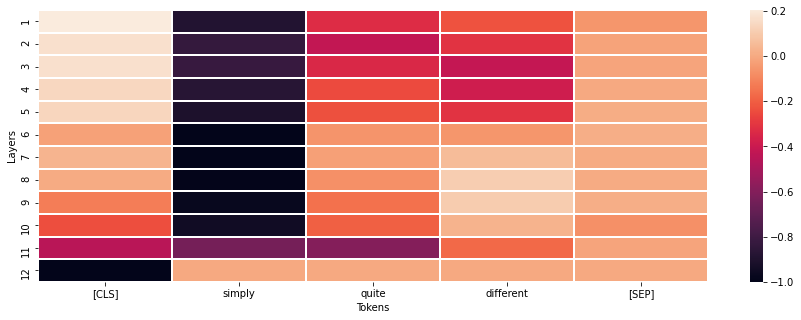

In [30]:
fig, ax = plt.subplots(figsize=(15,5))
xticklabels=all_tokens
yticklabels=list(range(1,13))
ax = sns.heatmap(np.array(layer_attrs), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
plt.xlabel('Tokens')
plt.ylabel('Layers')
plt.show()

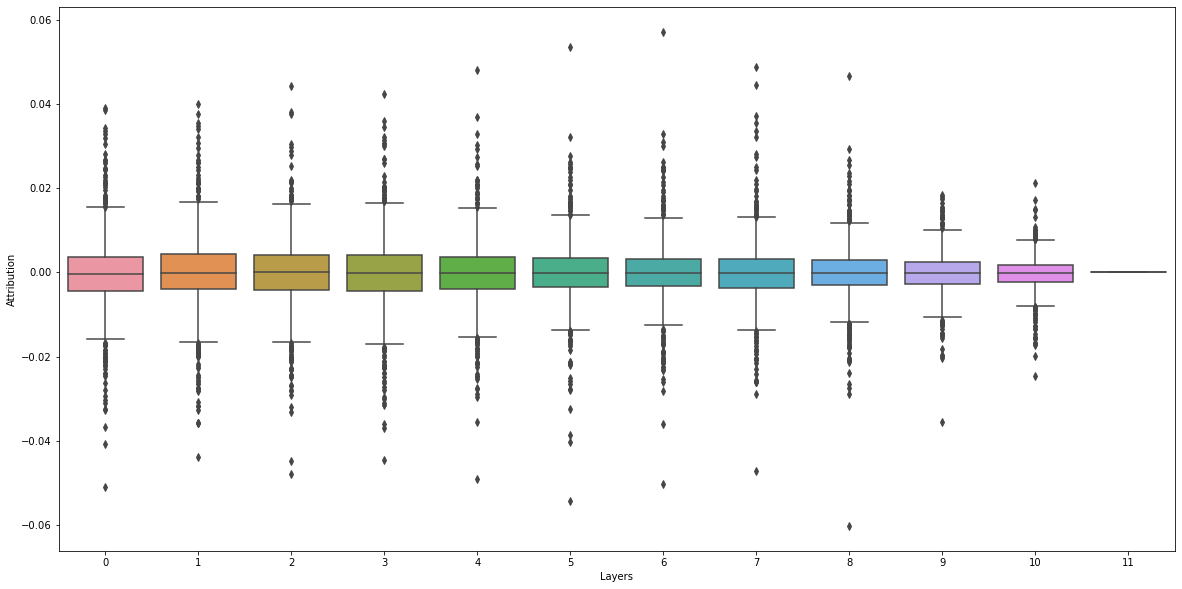

In [31]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(data=layer_attrs_dist)
plt.xlabel('Layers')
plt.ylabel('Attribution')
plt.show()

In [32]:
def pdf_attr(attrs, bins=100):
    return np.histogram(attrs, bins=bins, density=True)[0]

In [33]:
layer_attrs_pdf = map(lambda layer_attrs_dist: pdf_attr(layer_attrs_dist), layer_attrs_dist)
layer_attrs_pdf = np.array(list(layer_attrs_pdf))

# summing attribution along embedding diemension for each layer
# size: #layers
attr_sum = np.array(layer_attrs_dist).sum(-1)

# size: #layers
layer_attrs_pdf_norm = np.linalg.norm(layer_attrs_pdf, axis=-1, ord=1)

#size: #bins x #layers
layer_attrs_pdf = np.transpose(layer_attrs_pdf)

#size: #bins x #layers
layer_attrs_pdf = np.divide(layer_attrs_pdf, layer_attrs_pdf_norm, where=layer_attrs_pdf_norm!=0)


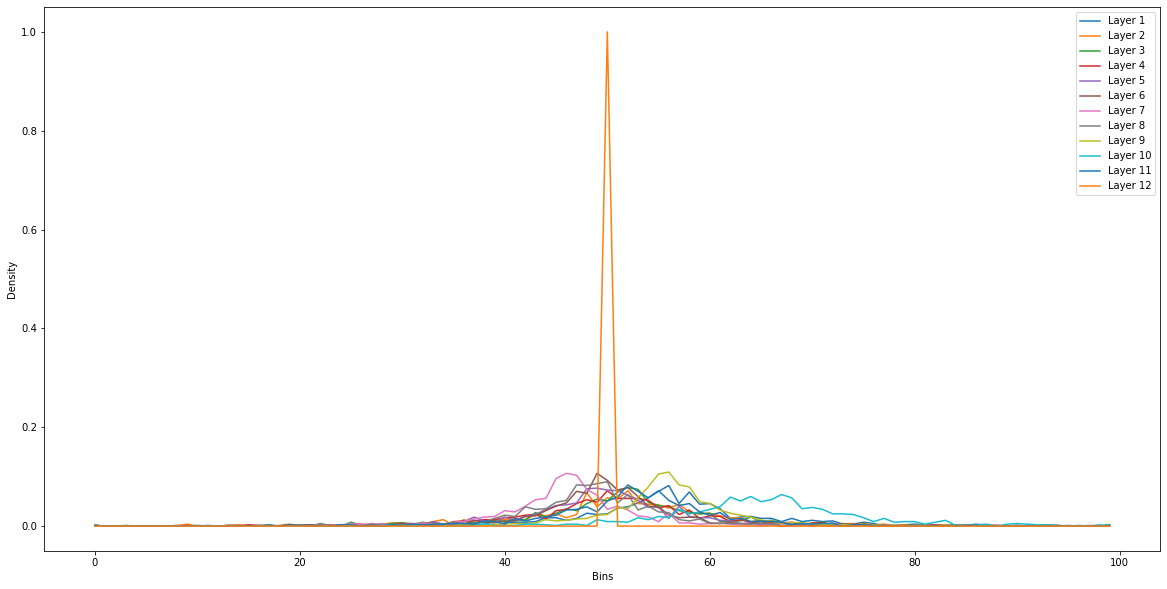

In [34]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(layer_attrs_pdf)
plt.xlabel('Bins')
plt.ylabel('Density')
plt.legend(['Layer '+ str(i) for i in range(1,13)])
plt.show()

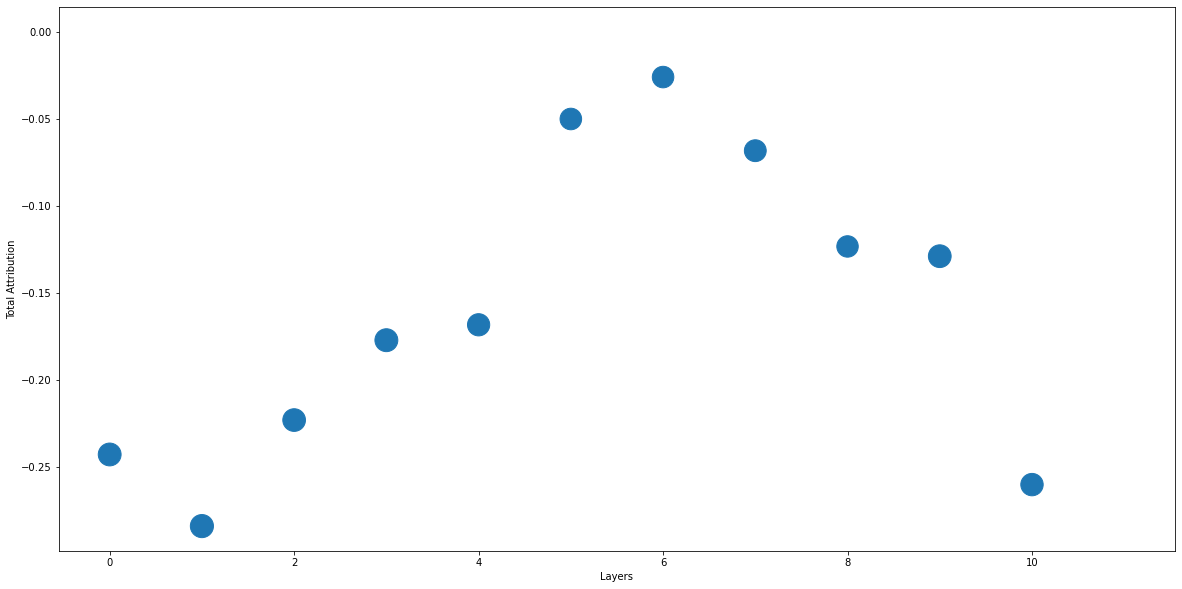

In [35]:
fig, ax = plt.subplots(figsize=(20,10))

# replacing 0s with 1s. np.log(1) = 0 and np.log(0) = -inf
layer_attrs_pdf[layer_attrs_pdf == 0] = 1
layer_attrs_pdf_log = np.log2(layer_attrs_pdf)

# size: #layers
entropies= -(layer_attrs_pdf * layer_attrs_pdf_log).sum(0)

plt.scatter(np.arange(12), attr_sum, s=entropies * 100)
plt.xlabel('Layers')
plt.ylabel('Total Attribution')
plt.show()